Jonathon Nguyen

ID: 801093003

Homework 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import datasets
import time

In [ ]:
# Find the normalized of the input tensor.
def normalized_data(tensor):
    mean = torch.mean(tensor)
    std = torch.std(tensor)
    new_tensor = (tensor - mean) / std
    
    return new_tensor

def training_loop(epochs, optimizer, model, loss_fn, training_vars, validation_vars, 
                  training_prices, validation_prices):
    for epoch in range(1, epochs + 1):
        prices_p_train = model(training_vars)
        loss_train = loss_fn(prices_p_train, training_prices)
        
        prices_p_val = model(validation_vars)
        loss_val = loss_fn(prices_p_val, validation_prices)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        print(f'Epoch {epoch}: Training Loss: {float(loss_train)}, Validation Loss: {float(loss_val)}')

In [ ]:
NUM_EPOCHS = 200

# Read the data from the provided CSV files
housing = pd.DataFrame(pd.read_csv("Housing.csv"))

# Split the data into the input vars and the prices.
names_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
prices = housing['price']

# Find the length of the column.
num_samples = len(prices)
num_val = int(0.2 * num_samples)

# Generate the random indices with 80% training and 20% Validation
random_indices = torch.randperm(num_samples)
training_indices = random_indices[:-num_val]
validation_indices = random_indices[-num_val:]

# Turn input, prices and params into a tensor
training_vars = []
validation_vars = []
for col in names_vars: 
    # Convert the column into a tensor.
    tensor = torch.tensor(housing[col]).float()
    
    # Split the data set and normalized the data.
    training_tensor = normalized_data(tensor[training_indices])
    validation_tensor = normalized_data(tensor[validation_indices])
    
    # Packing the tensor into a list to pass as a param
    training_vars.append(training_tensor)
    validation_vars.append(validation_tensor)
    
training_vars = torch.stack(training_vars[:]).permute(1, 0)
validation_vars = torch.stack(validation_vars[:]).permute(1, 0)


# Convert the prices to a tensor.
prices = torch.tensor(prices.values).float()
price_training = prices[training_indices]
price_validation = prices[validation_indices]

housing[names_vars]

In [ ]:

model = nn.Sequential(
        nn.Linear(5, 8),
        nn.Tanh(),
        nn.Linear(8, 1))

optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
training_loop(NUM_EPOCHS, optimizer, model, nn.MSELoss(), training_vars, validation_vars, price_training, price_validation)

Problem 2

In [2]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
])

def training_loop(epochs, optimizer, model, loss_fn, train_loader, val_loader):
    training_losses = []
    val_losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        # Temp vars for use in finding the accuracy.
        correct_labels = 0
        count = 0
        loss_val_value = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                # Pass imgs through the model and find the loss.
                output = model(imgs.view(imgs.shape[0], -1))
                loss_val = loss_fn(output, labels)
                loss_val_value += float(loss_val)
                
                # Find the accurcey of the model.
                _, predicted = torch.max(output, dim=1)
                count += labels.shape[0]
                correct_labels += int((predicted == labels).sum())
            
            # Store the loss and accuracy.
            loss_val_value /= count
            val_losses.append(loss_val_value)
            accuracies.append(correct_labels/count)
        
        loss_train_value = 0
        for imgs, labels in train_loader:
            # Pass imgs through the model and find the loss.
            output = model(imgs.view(imgs.shape[0], -1))
            loss_train = loss_fn(output, labels)
            
            # Adject the params
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        # Store the loss
        loss_train_value /= count
        training_losses.append(loss_train_value)
        
        # Print out the loss every 10 epoch
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch: {epoch}, Training Loss: {loss_train}, Validation Loss: {loss_val}, Accuracy: {(correct_labels/count)*100}%")
        
    return training_losses, val_losses, accuracies

In [3]:
# Download the cifar10 dataset.
data = '.\cifar10'
cirfar10_train = datasets.CIFAR10(data, train=True, download=True, transform=transforms)
cirfar10_val = datasets.CIFAR10(data, train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024

# Neural Net with one hidden layer of 512
model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 10),
        nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Load the data into a dataloader.
train_loader = torch.utils.data.DataLoader(cirfar10_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(cirfar10_val, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
# Using time to time the training.
start_time = time.time()
training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
end_time = time.time()

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1]}, Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 10, Training Loss: 1.7916094064712524,                  Validation Loss: 1.7688019275665283, Accuracy: 39.61%
Epoch: 20, Training Loss: 1.67167329788208,                  Validation Loss: 1.7150737047195435, Accuracy: 41.78%
Epoch: 30, Training Loss: 1.6277861595153809,                  Validation Loss: 1.6835988759994507, Accuracy: 42.9%
Epoch: 40, Training Loss: 1.6090425252914429,                  Validation Loss: 1.6632529497146606, Accuracy: 43.86%
Epoch: 50, Training Loss: 1.57368004322052,                  Validation Loss: 1.6431949138641357, Accuracy: 44.34%
Epoch: 60, Training Loss: 1.501617431640625,                  Validation Loss: 1.6230076551437378, Accuracy: 45.09%
Epoch: 70, Training Loss: 1.4647669792175293,                  Validation Loss: 1.6075302362442017, Accuracy: 45.72%
Epoch: 80, Training Loss: 1.5113509893417358,                  Validation Loss: 1.5947539806365967, Accuracy: 46.0%
Epoch: 90, Training Loss: 1.4188315868377686,                  Validati

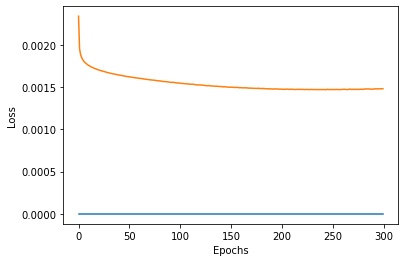

In [6]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')

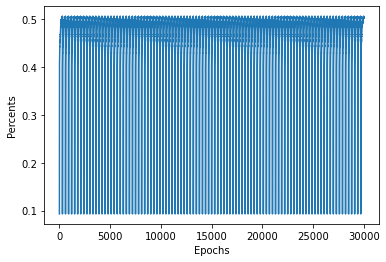

In [7]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

plt.plot(accuracies * 100, label='Accuracy')

In [ ]:
# Two new layers in the model.
model_new = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 1024),
            nn.Tanh(),
            nn.Linear(1024, 256),
            nn.Tanh(),
            nn.Linear(256, 10),
            nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()
optimizer = optim.SGD(model_new.parameters(), lr=LEARNING_RATE)

# Using new model in the loop. Timing it with the same method.
start_time = time.time()
training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model_new, loss, train_loader, val_loader)
end_time = time.time()

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1]}, Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 10, Training Loss: 1.8093847036361694,                  Validation Loss: 1.8428081274032593, Accuracy: 36.02%
Epoch: 20, Training Loss: 1.766709327697754,                  Validation Loss: 1.7592021226882935, Accuracy: 39.24%
Epoch: 30, Training Loss: 1.7386857271194458,                  Validation Loss: 1.7148411273956299, Accuracy: 40.9%
Epoch: 40, Training Loss: 1.6488807201385498,                  Validation Loss: 1.6898365020751953, Accuracy: 42.16%
Epoch: 50, Training Loss: 1.669877290725708,                  Validation Loss: 1.6648982763290405, Accuracy: 43.36%
Epoch: 60, Training Loss: 1.5854144096374512,                  Validation Loss: 1.6414361000061035, Accuracy: 44.28%
Epoch: 70, Training Loss: 1.5398234128952026,                  Validation Loss: 1.6127463579177856, Accuracy: 45.050000000000004%
Epoch: 80, Training Loss: 1.4959840774536133,                  Validation Loss: 1.5911458730697632, Accuracy: 45.769999999999996%
Epoch: 90, Training Loss: 1.4490944147109

In [ ]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')

In [ ]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

plt.plot(accuracies * 100, label='Accuracy')